---
#### 타이타닉 생존여부 예측 모델
---

1. 예측 모델 처리 순서
    - 목표 설정 : 가장 중요
    - 데이터 수집
    - 데이터 분석(시각화)
    - 데이터 전처리
    - 모델 학습
    - 모델 성능 평가 : 성능이 떨어지면 위로 다시 돌아가야 한다.


In [1]:
# 데이터 로드 및 기본 정보 확인
# 데이터 집합 : train.csv, test.csv(사용하지 않는다)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('./data/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


####

#### 주요 컬럼 정리
- Survived(목표변수, 원래답) : 0(사망), 1(생존)
- Pclass(등급) : 1등석(1), 2등석(2), 3등석(3)
- Sex(성별) : male(남성), female(여성)
- Age(나이) : 데이터 타입 float, 실수다
    - 연속데이터다 => 범주형 변경 필요, 카테고리별 데이터
- SibSp(형제/배우자 수) : 명수
- Parch(부모/자식 수) : 명수
- Cabin(방이름) : C001, D002, E
- Fare(티켓요금) : 
- Embarked(승선 항구) : C(Cherbourg), Q(Queenstown), S(Southampton)

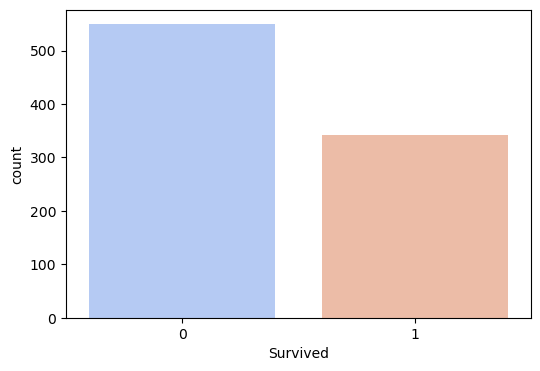

In [3]:
# 탐색적 데이터 분석(EDA)
# 1. 생존자(목표변수) 비율 : 불균형 데이터 셋, 사망자가 60% 이상 된다.
plt.figure(figsize=(6,4))
sns.countplot(
    data=train_df
    , x='Survived'
    , palette='coolwarm'
)
plt.show()

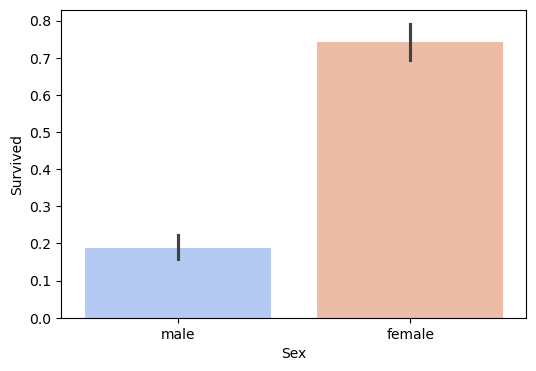

In [4]:
# 2. 성별과 생존 관계를 시각화
plt.figure(figsize=(6,4))

sns.barplot(
    data=train_df
    , x='Sex'
    , y='Survived'
    , palette='coolwarm'
)

plt.show()

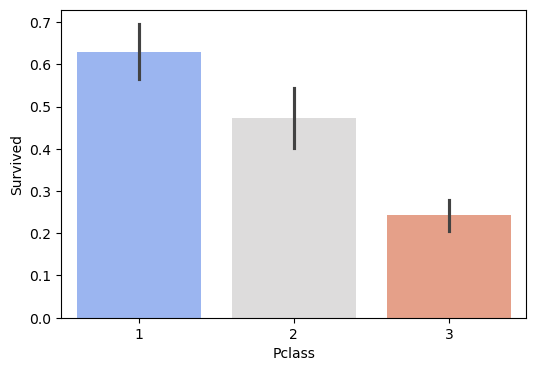

In [5]:
# 3. 등급과 생존 관계
plt.figure(figsize=(6,4))

sns.barplot(
    data=train_df
    , x='Pclass'
    , y='Survived'
    , palette='coolwarm'
)

plt.show()

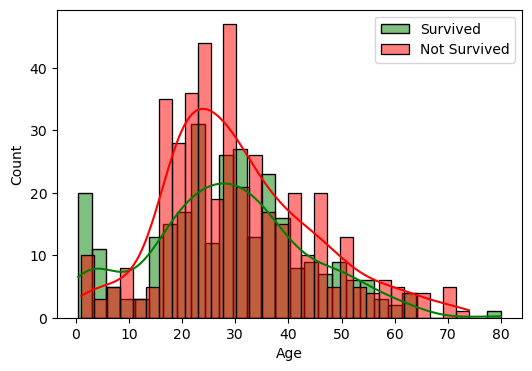

In [6]:
# 4. 나이(연속데이터)와 생존 관계
# 히스토그램
# 2. 성별과 생존 관계 시각화
plt.figure(figsize=(6,4))

# 생존 데이터 관련
# 산사람들의 나이에 대한 분포를 그리겠다는 뜻
sns.histplot(
    x=train_df[train_df['Survived']==1]['Age']
    , bins=30 # 30개 구간으로 나누고 밀도
    , color='green'
    , kde=True # 곡선 표시 여부 
    , label='Survived'
)

# 사망 데이터 관련
sns.histplot(
    x=train_df[train_df['Survived']==0]['Age']
    , bins=30 # 30개 구간으로 나누고 밀도
    , color='red'
    , kde=True # 곡선 표시 여부 
    , label='Not Survived'
)

plt.legend()
plt.show()

# 어린이(10세 이해)의 생존율이 높음
# 20대~40대 성인 남성의 생존율이 낮음

In [7]:
(train_df['Survived']==0).sum()

np.int64(549)

In [8]:
(train_df['Survived']==1).sum()

np.int64(342)

In [9]:
# train_df[train_df['Survived']==1]['Age'] # 생존한 사람의 나이 추출

---
#### 연속형 데이터를 범주형 데이터 변환
---

1. 왜 나이를 범주형 데이터로 변환하는가?
    - 연속형 데이터의 문제점
        - 나이는 0세부터 80세 이상가지 연속 값을 가지고 있는데, 특정 연령대가 생존율과 강한 연관성이 있더라도 머신러닝이 모델이 학습하기 어렵다
    - 분류 모델(결정트리, 랜덤포레스트, XGBoost 등)들은 연속형 값보다 범주형 변수를 학습 더 잘할 수 있다.
    - 장점
        - 이상치 데이터에 의한 학습 문제 완화

In [10]:
# 범주화 방법
# 1. 등간격 방법(Equal Interval) : 일정한 간격으로 나누는 방법(10대,20대....)
# 나이 구간을 5개로 나누기(0~16:0, 17~32:1, 33~48:2, 49~64:3, 65+:4)
# 장점 : 특정 구간에서 생존율이 비슷한지 비교가능
# 단점 : 데이터 분포와 상관없이 균등하게 나누므로, 특정 그룹이 너무 많거나 적을 수 있다.
age_bin=pd.cut(
    train_df['Age']
    , bins=[0,16,32,48,64,100]
    , labels=[0,1,2,3,4]
)
age_bin


0        1
1        2
2        1
3        2
4        2
      ... 
886      1
887      1
888    NaN
889      1
890      1
Name: Age, Length: 891, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [11]:
# 2. 분위수 기반(Quantile Binning) : 데이터를 동등한 개수의 그룹으로 나누는 방법
# 해석
# 1사분위 : (최소~25%) : 0
# 2사분위 : (25%~50%) : 1
# 3사분위 : (50%~75%) : 2
# 4사분위 : (75%~최대) : 3
# 장점 : 각 그룹에 데이터가 균등하게 분포되도록 나뉘므로 데이터 불균형을 방지
# 단점 : 나이에 의미적 구분이 불분명할 수 있다.
age_bin=pd.qcut(
    train_df['Age']
    , q=4 # 4분위를 주겠다는 뜻
    , labels=[0,1,2,3]
)
age_bin

0        1
1        2
2        1
3        2
4        2
      ... 
886      1
887      0
888    NaN
889      1
890      2
Name: Age, Length: 891, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

In [12]:
# 3. 의미 기반 그룹화(도메인 지식 활용) : 연령대를 실제 생존율 패턴에 맞춰 직접 지정
# 10대, 20대
# 람다 함수
# 장점 : 실제 생존율 패턴과 관련이 있는 연령대 구분
# 단점 :(균등하지 않으면)성능이 떨어질 수 있다.
age_bin=train_df['Age'].apply(
    lambda x : 0 if x <= 10 else # 0~10살 까지는 0으로 바꾸겠다.
                1 if x <= 20 else
                2 if x <= 30 else
                3 if x <= 40 else
                4 if x <= 50 else
                5 if x <= 60 else
                6  
)
age_bin

0      2
1      3
2      2
3      3
4      3
      ..
886    2
887    1
888    6
889    2
890    3
Name: Age, Length: 891, dtype: int64

#### 결론 및 정리

1. 언제 범주형 변환을 사용할까?
    - 결정트리기반 모델(Random Forest, XGBoost)에서는 범주형 변환이 유용할 수 있다.
    - 데이터가 비선형관계일 경우, 연속형보다 범주형 변수가 성능이 더 좋을 수 있다.
    - 데이터가 적거나 이상치가 많을 때 범주화하면 안정적인 학습이 가능
2. 어떤 상황에서 어떤 방법이 좋을까?
    - 데이터가 충분히 많다면 분위수 변환(qcut)이 일반적으로(무조건x) 성능이 좋다.
    - 의미적인 구분이 필요하다면 도메인 지식 기반 그룹화가 더 직관적일 수 있다.
    - 기본적으로는 등간격 변환 후 다른 방식의 성능을 비교하는 방식으로 추천

3.12 수

---
#### 데이터 종류
---

 데이터 크게 두 가지로 구분된다

 1. 질적 데이터(Qualitative Data, 범주형데이터) -> 수치화할 수 없는 데이터
 2. 양적 데이터(Quantitative Data, 수치형데이터) -> 수치로 측정되는 데이터

 - 각각의 세부 유형과 특징
    - 질적데이터
        - 명목형(Nominal) : 순서가 없음
            - 예시 : 성별, 혈액형, 국적
            - 분석방법 : 빈도 분석, 카이제곱검정(범주형데이터 간의 관계를 검정)
        - 서열형(Ordinal) : 순서가 있는 명목형 데이터
            - 예시 : 고객만족도, 학점
            - 분석방법 : 중앙값 분석, 순위 상관 분석
    - 양적데이터
     - 이산형데이터(Discrete)
        - 예시 : 고객 방문 횟수(1,2,3), 자녀수
        - 분석방법 : 평균, 분산, 포아송분포
    - 연속형데이터(Continuous)
        - 예시 : 키, 몸무게, 온도
        - 분석방법 : 평균, 표준편차(STD), 정규분포

In [13]:
# 2. 질적 데이터(범주형 데이터)의 통계적 접근
# 질적 데이터는 숫자로 연산할 수 없기 때문에 비율, 빈도 분석이 핵심이다.
# 2.1 명목형 데이터(Nominal Data)
# 데이터 간 순서가 없으며, 단순히 범주를 나타낸다.
# 빈도 분석(Frequency Analysis) : 각 범주의 개수를 비교해서 분포를 파악
# 성별 빈도 분석 // 개수 파악
import numpy as np
import pandas as pd

data = pd.DataFrame({
    'Gender':['Male','Female','Female','Male','Male']
})

# 빈도 분석
print(data['Gender'].value_counts())

Gender
Male      3
Female    2
Name: count, dtype: int64


In [14]:
# 결과가 series로 나온다.

In [15]:
# 카이제곱 검정(Chi-Square Test)
# 범주형 데이터 간의 관계를 검정(의미가 있냐, 없냐)할 때 사용
# 예 : 성별과 생존 여부 관계 검정
from scipy.stats import chi2_contingency

# 성별과 생존 여부 교차표
# data=np.array([[50,100],[80,70]])
# [50,100] : 남성의 생존, 사망
# [80,70] : 여성의 생존, 사망
data=np.array([[50,100],[80,70]])
chi2, p, _, _ =  chi2_contingency(data) # 원래 4개 값인데 두개만 받고 싶을때 _ 사용
print(f'P-value : {p}')
# P-value < 0.05이면 성별과 생존 여부 간에 유의미한 차이가 있다는 뜻

P-value : 0.000728029450456362


In [16]:
# 0.05보다 작으면 의미가 있다.
# = 성별에 따라서 죽고 사느냐 영향이 있다. 

In [17]:
# 2. 서열형 데이터(Ordinal Data)
# 데이터 간 순서는 있지만 간격이 일정하지 않은 데이터 // 간격이 일정하지 않다? 평균을 때리면 안된다.
# 중앙값(Median) 분석
# 목적 : 평균을 사용하기 어려울 때 사용
data=np.array([1,2,2,3,4,5]) # 1:불만족, 5:매우만족
np.median(data)

np.float64(2.5)

In [18]:
# 고객만족도(서열)와 재구매(서열) 횟수의 상관관계 분석
# 서열 데이터 간의 상관관계를 분석하는 방법
# 스피어만 순위 상관 분석(Spearman's Rank Correlation)

# data 생성
x=[1,2,3,2,1] # 만족도 => P-value : 0.013846832988859107 = 의미있다.
x=[1,2,3,4,5] # 만족도 => P-value : 0.6238376647810728 = 의미없다.
y=[10,20,30,25,15] # 재구매

from scipy.stats import spearmanr
corr, p=spearmanr(x,y)
# p-value < 0.05이면 만족도가 높을수록 재구매율이 높다는 결론을 내릴 수 있다.
print(f'Spearman Correlation : {corr}, P-value : {p}')

Spearman Correlation : 0.3, P-value : 0.6238376647810728


In [19]:
# 3. 양적데이터(수치데이터)의 통계적 접근 방법
# 양적데이터는 평균, 분산, 회귀분석 등을 활용하여 분석
# 3.1 이산데이터(Discrete Data)
# 보통 정수값만 가짐
# 평균, 분산 분석
data=np.array([2,3,5,7,1,0,4])
print(f'평균 : {np.mean(data)}, 분산 : {np.var(data)}')
# 분산이 크면 데이터 값들이 평균에서 많이 벗어나 있다는 의미
# 머신러닝, 딥러닝에서 데이터가 분산이 크면 학습이 잘 안되거나 발산(수렴반대말)이 발생할 수 있다.

평균 : 3.142857142857143, 분산 : 4.979591836734694


In [20]:
# 포아송분포(함수) : 특정 시간동안 발생하는 이벤트 횟수 예측
# 예 : 1시간동안 고객 방문자 수 예측
import scipy.stats as stats

mu=3 # mu = 모집단(전체데이터) 평균
data=[0,1,2,3,4,5] # 데이터
poisson_dist=stats.poisson.pmf(data,mu)
print(poisson_dist)

[0.04978707 0.14936121 0.22404181 0.22404181 0.16803136 0.10081881]


In [21]:
import numpy as np

# 3.2 연속형 데이터(Continuous Data)
# 소수점 포함
# 평균, 분산, 표준편차 : 크면 데이터가 평균으로부터 넓게 퍼져 있음을 의미
# 너무 과하면 학습이 잘 안된다.
data=np.array([170,165,180,175,160]) # 키 데이터
print(f'평균 : {np.mean(data)}, 표준편차 : {np.std(data)}, 분산 : {np.var(data)}')

평균 : 170.0, 표준편차 : 7.0710678118654755, 분산 : 50.0


In [22]:
# 정규분포 검정 : 데이터가 정규분포를 따르는지 안따르는지 여부
from scipy.stats import shapiro

data=np.random.normal(0,1,100) # 평균:0, 표준편차:1, 100개 데이터 생성
stat, p = shapiro(data)
print(f'p-value : {p}') # f(문자열:변수)
# p-value < 0.05이면 데이터가 정규분포를 따르지 않음을 의미
# 머신러닝은 데이터가 정규분포를 따른다는 가정하에 알고리즘들이 만들어져 있다. 
# 결국 데이터가 정규분포를 따르지 않으면 머신러닝 학습은 제대로 되지 않는다.
# But 딥러닝은 다르다.

p-value : 0.5078340737469579


---
##### 결론
---

1. 질적 데이터(명목형, 서열형) : 카이제곱 검정, 빈도분석, 순위상관분석 활용
2. 양적 데이터(이산, 연속) : 평균, 분산, 정규성 검정, 회귀분석 등 활용
3. 데이터 유형에 따라 적절한 통계적 접근 방법 선택해야 한다. 

---
##### 결측치 처리
---
(머신러닝은 결측치가 있다고 해서 에러가 아님 but 딥러닝은 결측치가 있으면 에러)
결측치(Missing Value)는 머신러닝 모델의 성능을 크게 저하시킬 수 있기 때문에 적절한 방법으로 처리해야 한다.

- 타이타닉 데이터 결측치 확인
- 결측치 처리 방법 

In [23]:
# 타이타닉 데이터에서 결측치 확인
# 데이터 로딩
train_df=pd.read_csv('./data/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
# 결측치 확인
missing_value=train_df.isnull().sum() / 891 #(전체개수) // 퍼센테지로 나온다.
missing_value

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [25]:
# Age(나이)가 20%정도 빠진거다.

In [26]:
# 결측치 시각화
import missingno as msno

<Axes: >

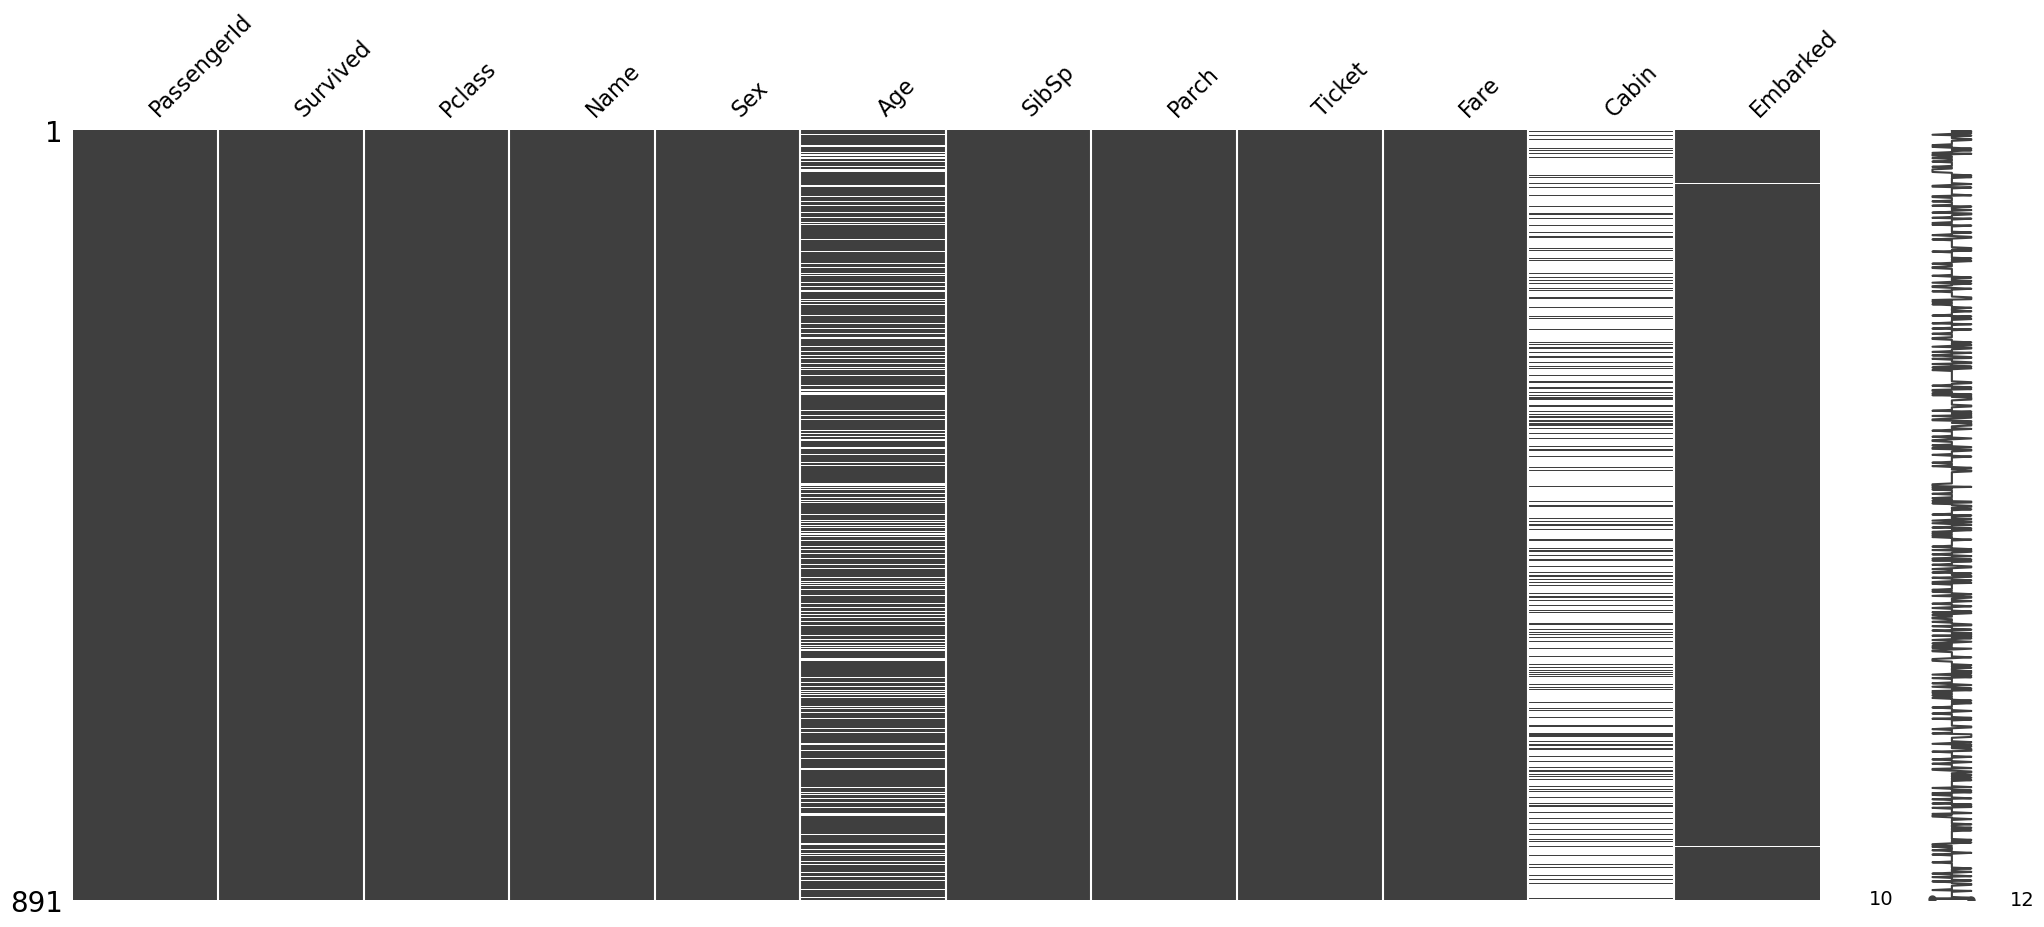

In [27]:
msno.matrix(train_df)
# 어느위치에 데이터가 없는지 확인하기가 쉽다.

<Axes: >

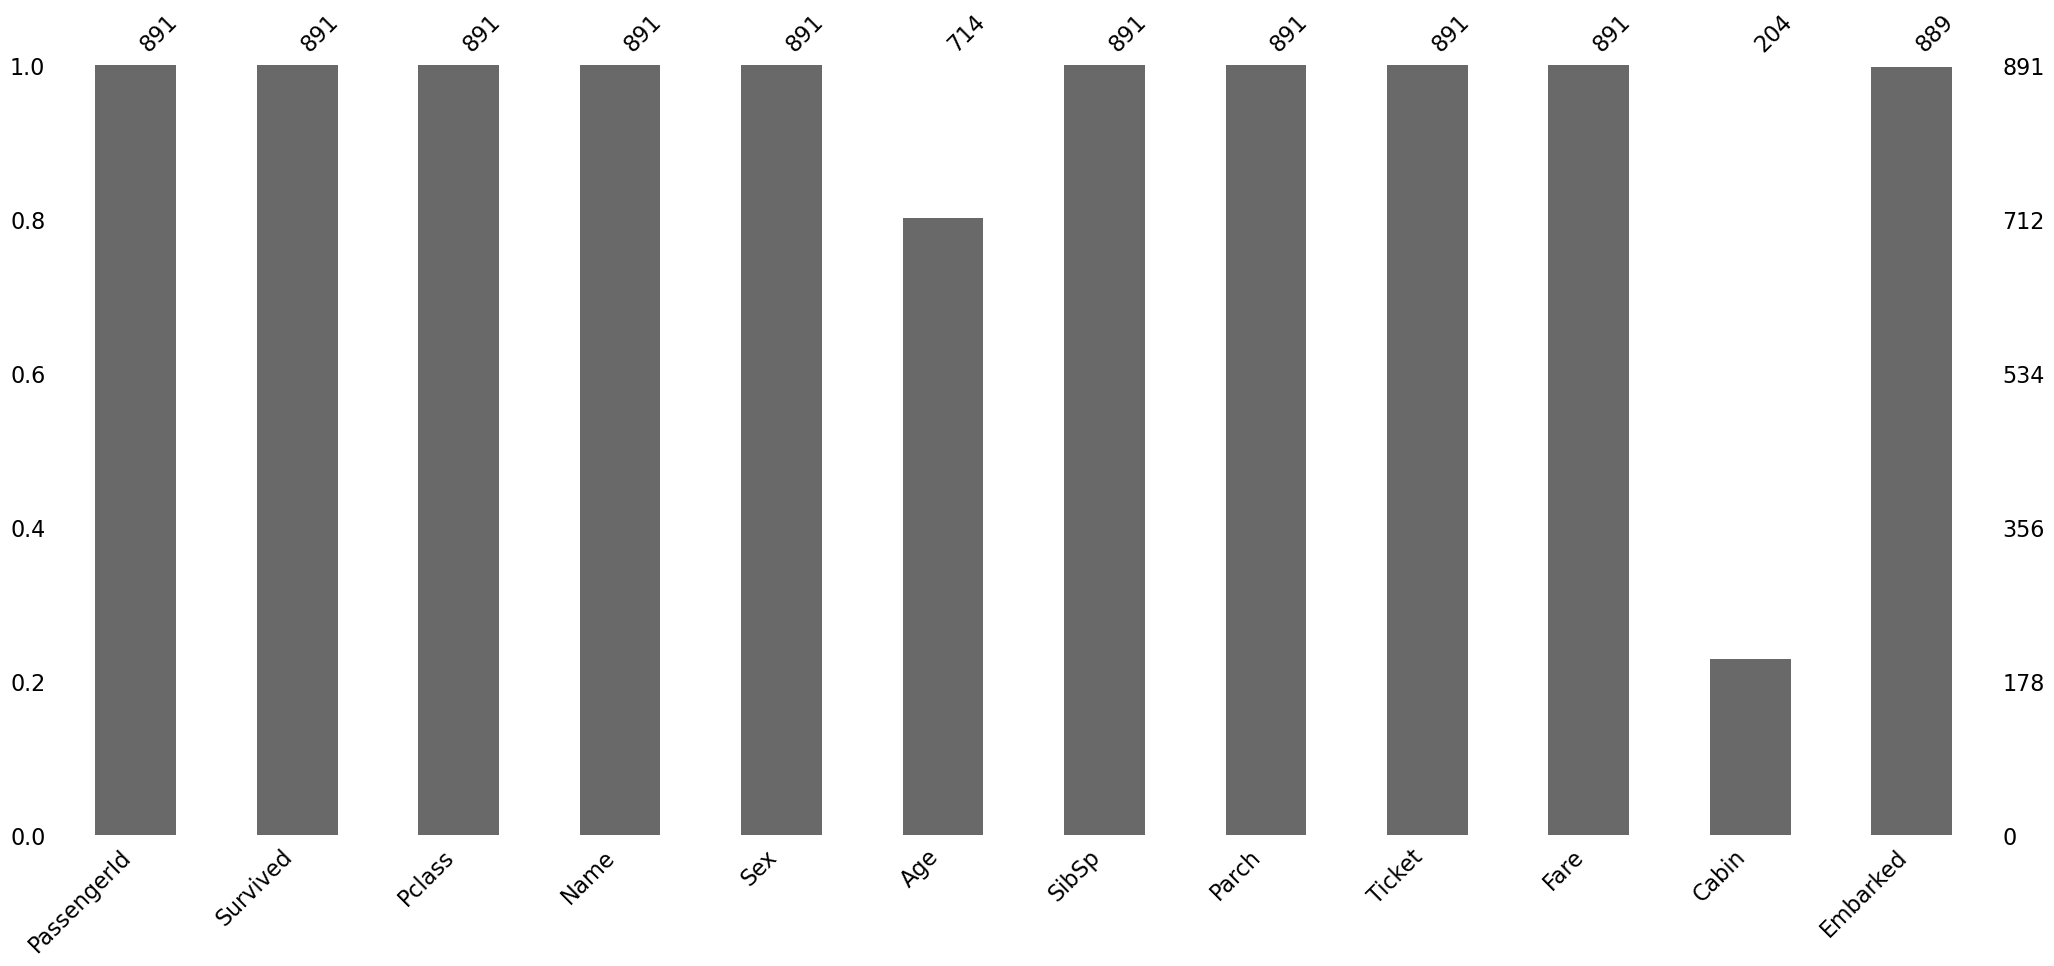

In [28]:
msno.bar(train_df)

In [29]:
# 2. 결측치 처리 방법
# 결측치 비율
# 5% 이하 : 전체 최빈값, 전체 평균값, 전체 중앙값으로 대체
# 5~30% : 특정(컬럼)그룹별 평균값, 중앙값으로 대체(예. Pclass별 Age 평균 대체)
# 30% 이상 : 삭제하거나, 새로운 범주 생성(예. cabin의 경우 'No Cabin'처럼 새로운 범주값을 추가)

In [30]:
# 나이(Age) 결측치 처리
# 방법1 : 전체 평균 또는 중앙값으로 대체 => 일단 올바른 방법은 아니다.
# 장점 : 빠르고 간단한 방법
# 단점 : 나이의 분포(함수)를 왜곡할 수 있다. // 나중에 예측모델도 오류가 생길 수 있다.
# 전체 평균으로 대체
train_df['Age'].fillna(train_df['Age'].mean(), inplace=False).isnull().sum()
# 전체 중위값으로 대체
train_df['Age'].fillna(train_df['Age'].median(), inplace=False).isnull().sum()

np.int64(0)

---
#### 판다스 groupby() function
---

groupby 함수는 데이터프레임에서 특정 기주으로 데이터를 그룹화하고 그룹별 연산을 수행할 수 있는 핵심 기능

- 기본 문법
    df.groupby('그룹핑할 컬럼').연산()
        - 연산 : sum(), mean(), count(), filter()

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 예제 데이터 생성
data = {
    "부서": ["영업", "영업", "마케팅", "마케팅", "인사", "인사", "인사"],
    "직원": ["김철수", "이영희", "박민수", "최지훈", "한지수", "정해인", "오세훈"],
    "급여": [500, 550, 620, 700, 450, 480, 500],
    "보너스": [50, 55, 60, 70, 45, 48, 50]
}
df = pd.DataFrame(data)
print(df)

    부서   직원   급여  보너스
0   영업  김철수  500   50
1   영업  이영희  550   55
2  마케팅  박민수  620   60
3  마케팅  최지훈  700   70
4   인사  한지수  450   45
5   인사  정해인  480   48
6   인사  오세훈  500   50


In [32]:
# 요건 : 부서별 급여 합
# df.groupby('부서') 부서별 그룹핑 오브젝트
df.groupby('부서').sum()['급여']


부서
마케팅    1320
영업     1050
인사     1430
Name: 급여, dtype: int64

In [33]:
df.groupby('부서')['급여'].sum()
# 이게 더 속도가 빠르다

부서
마케팅    1320
영업     1050
인사     1430
Name: 급여, dtype: int64

In [34]:
# 부서별 평균 급여
df.groupby('부서')['급여'].mean()

부서
마케팅    660.000000
영업     525.000000
인사     476.666667
Name: 급여, dtype: float64

In [35]:
# 다중 컬럼으로 그룹핑
df.groupby(['부서','직원'])[['급여','보너스']].sum()

급여  보너스
부서  직원           
마케팅 박민수  620   60
    최지훈  700   70
영업  김철수  500   50
    이영희  550   55
인사  오세훈  500   50
    정해인  480   48
    한지수  450   45

In [36]:
# 인덱스(부서)를 컬럼으로 보내기
# 인덱스에 표시한 named index를 다시 컬럼으로 보내기
# reset_index()
# df.groupby('부서')[['급여','보너스']]
df.groupby('부서')[['급여','보너스']].sum().reset_index()

,부서,급여,보너스
0,마케팅,1320,130
1,영업,1050,105
2,인사,1430,143


In [37]:
# 그룹별 필터링(filter)
# 특정 조건을 만족하는 그룹만 선택
# 부서별 급여의 평균이 500이상인 부서와 데이터 출력
# x: Dataframegroupby
df.groupby('부서').filter(lambda x:x['급여'].mean() > 500)


,부서,직원,급여,보너스
0,영업,김철수,500,50
1,영업,이영희,550,55
2,마케팅,박민수,620,60
3,마케팅,최지훈,700,70


In [38]:
# 그룹별 변환(transform)
df['급여_평균']=df.groupby('부서')['급여'].transform('mean')
df

,부서,직원,급여,보너스,급여_평균
0,영업,김철수,500,50,525.000000
1,영업,이영희,550,55,525.000000
2,마케팅,박민수,620,60,660.000000
3,마케팅,최지훈,700,70,660.000000
4,인사,한지수,450,45,476.666667
5,인사,정해인,480,48,476.666667
6,인사,오세훈,500,50,476.666667


In [39]:
# 그룹별 사용자 정의 함수 적용 apply()
# 요건 : 부서별 최대급여와 최소급여 차이
df.groupby('부서')['급여'].apply(lambda x: x.max() - x.min())


부서
마케팅    80
영업     50
인사     50
Name: 급여, dtype: int64

In [40]:
# 결측치 대체 : fillna()
# 방법2 Pclass 별 평균 나이로 대체
train_age = \
    train_df.groupby('Pclass')['Age'].transform(lambda x:x.fillna(x.mean()))
train_age.isnull().sum()

np.int64(0)

In [ ]:
# 방법 3 : 머신러닝 알고리즘을 이용해서 결측치값을 예측하고 대체 
# 장점 : 데이터 패턴을 학습하여 더 정밀한 값으로 대체 모델의 성능 향상 기대 가능
# 단점 : 시간이 걸린다, 반드시 성능 향상을 기대하면 안된다.
# Age를 예측하는 모델을 만들어서 결측값을 채울 수 있다.
# RandomForest (분류, 회귀(나이: 연속값))
from sklearn.ensemble import RandomForestRegressor

# 나이 예측에 필요한 컬럼(변수, 피처) 선택
age_data=train_df[['Age','Pclass','SibSp','Parch','Fare']]
# age_data.shape => (891, 5)
age_data

,Age,Pclass,SibSp,Parch,Fare
0,22.0,3,1,0,7.2500
1,38.0,1,1,0,71.2833
2,26.0,3,0,0,7.9250
3,35.0,1,1,0,53.1000
4,35.0,3,0,0,8.0500
...,...,...,...,...,...
886,27.0,2,0,0,13.0000
887,19.0,1,0,0,30.0000
888,NaN,3,1,2,23.4500
889,26.0,1,0,0,30.0000


In [ ]:
# 결측치가 없는 행 : 학습데이터로 사용, 결측치 행 삭제해서 추출 = dropna()
train_no_missing=age_data.dropna() # 결측치를 삭제하라는 뜻
train_no_missing.shape # (714, 5) 

# 결측치가 있는 행 : 예측나이 추출 
# 결측치가 있는 행을 찾자 : Boolean
# age_data['Age'].isnull() # True인게 null // return = dataframe
# age_data[age_data['Age'].isnull()] # null인게 true // 177개 나옴
# 나이 예측에 사용할 데이터 => 대체 
train_missing = age_data[age_data['Age'].isnull()].drop('Age', axis=1)
train_missing.shape # (177, 4)

(177, 4)

In [ ]:
# 학습데이터를 데이터(4개컬럼)와 답(나이)으로 분리
# 대문자 = 행렬, 소문자 = 벡터
# 학습데이터 = X
X_train=train_no_missing.drop('Age', axis=1, inplace=False) # 삭제하고 나머지 반환
# 답(나이컬럼) 추출
y_train=train_no_missing['Age']

# 모델 생성
# n_estimators=100 , random_state=42
model=RandomForestRegressor(n_estimators=100, random_state=42)
# 학습 끝나면 모델(함수, 오차가 최소가 되는 식) 완성
# model.fit() => 학습시키는 함수
model.fit(X_train, y_train)

# 나이의 결측치를 채울 예측 나이 추출 후 대체
# 예측
# model.predict() => 예측값 뽑아내주는 함수, model.predict(train_missing) => 예측 나이 추출
train_df.loc[train_df['Age'].isnull(), 'Age'] = model.predict(train_missing)
# train_df['Age'].isnull(), 'Age' // ['Age'].isnull() = 헹, 'Age' = 열 // loc = 네임드컬럼이용

<Axes: >

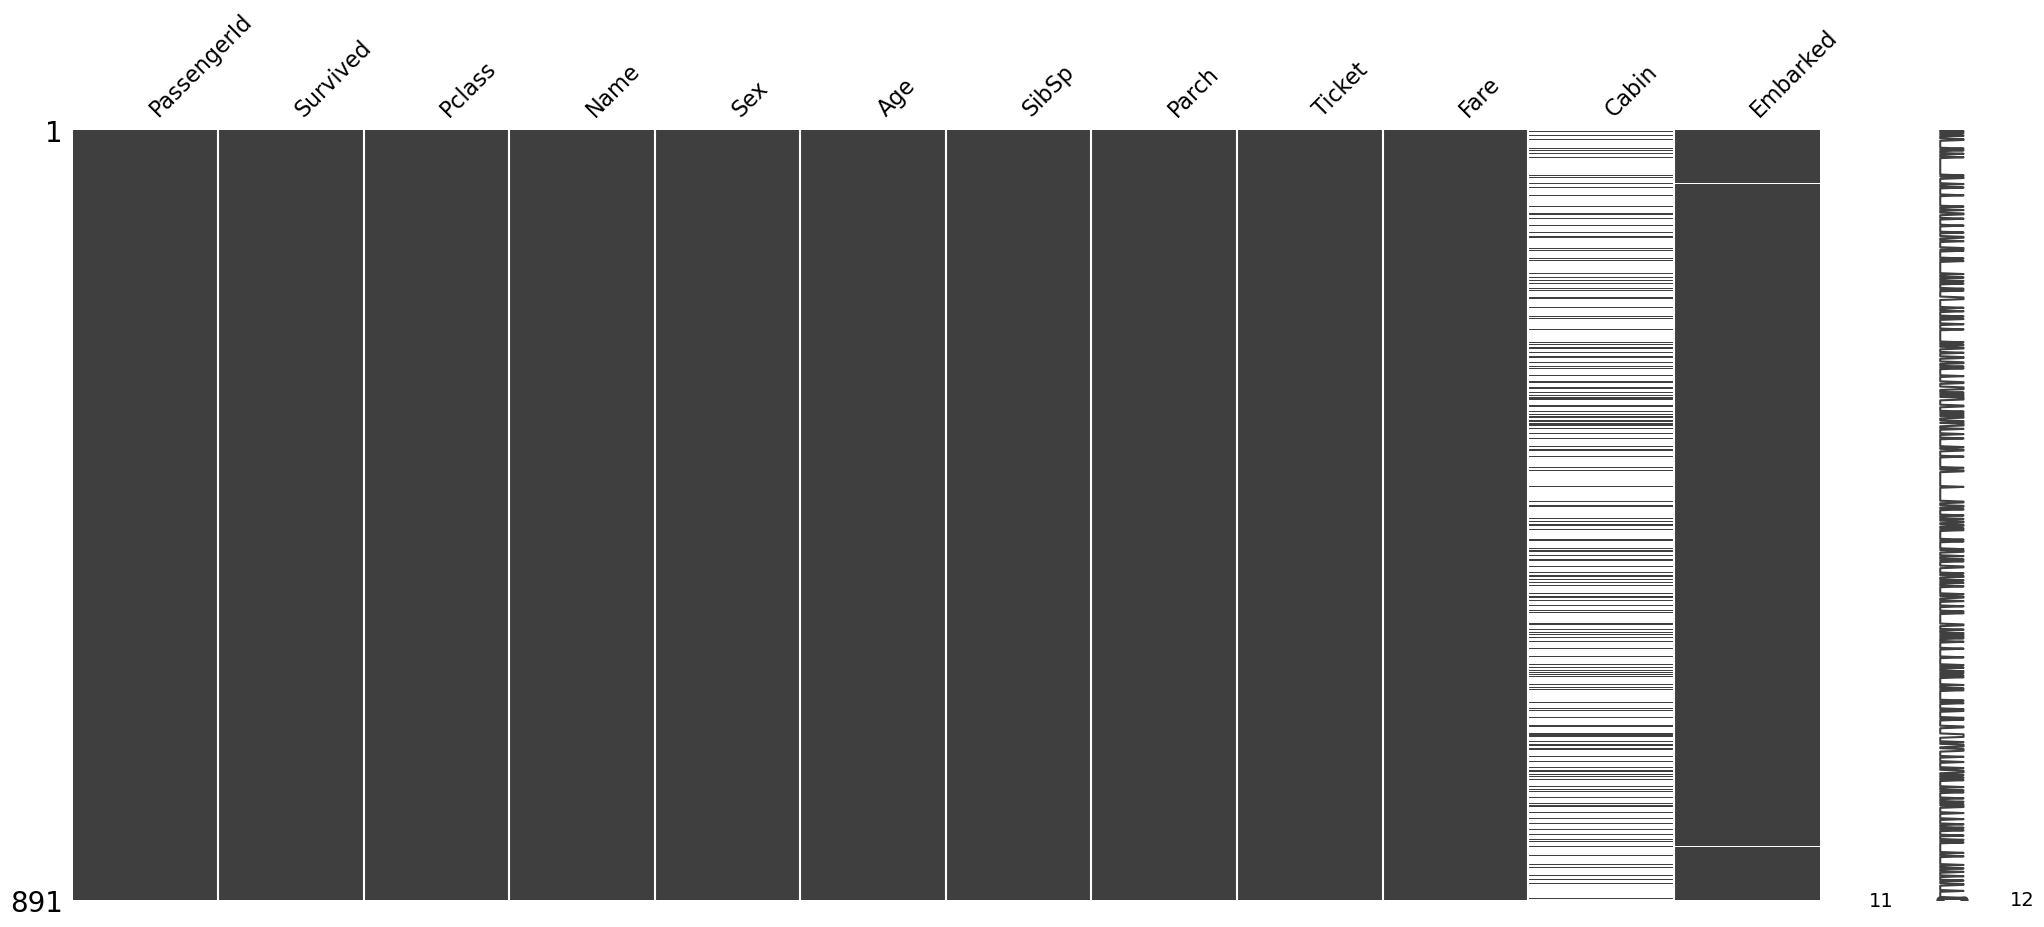

In [ ]:
msno.matrix(train_df)
# 나이가 꽉 차버렸다!!!!!!!!!!!!!!!